In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

``Data loading``

In [326]:
df_arrivals = pd.read_csv('../data/df_arrivals.csv')
df_departures = pd.read_csv('../data/df_departures.csv')
df_low_cost = pd.read_csv('../data/Low_Cost_Airlines.csv')
df_international_airports = pd.read_csv("../data/List_of_international_airports_by_country.csv")


plt.style.use("ggplot")

In [272]:
df_arrivals.shape, df_departures.shape, df_low_cost.shape

((77577, 20), (77577, 20), (179, 1))

In [273]:
def get_nan_rows(df):
    null_df = [df[df[column].isna()] for column in df.columns]
    stats_df = [(column, df[column].isna().sum(), (df[column].isna().sum() / df.shape[0]) * 100) for column in df.columns]
    stats_df = pd.DataFrame(stats_df, columns=["column", "nan_count", "nan_percentage"])
    return null_df, stats_df


def plot_nan_percentage_camembert(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    plt.pie(stats_df["nan_percentage"], labels=stats_df["column"], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    plt.show()

    return stats_df

def plot_nan_percentage(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    sns.barplot(x="nan_percentage", y="column", data=stats_df, orient="h")
    plt.title(title)
    plt.show()

    return stats_df

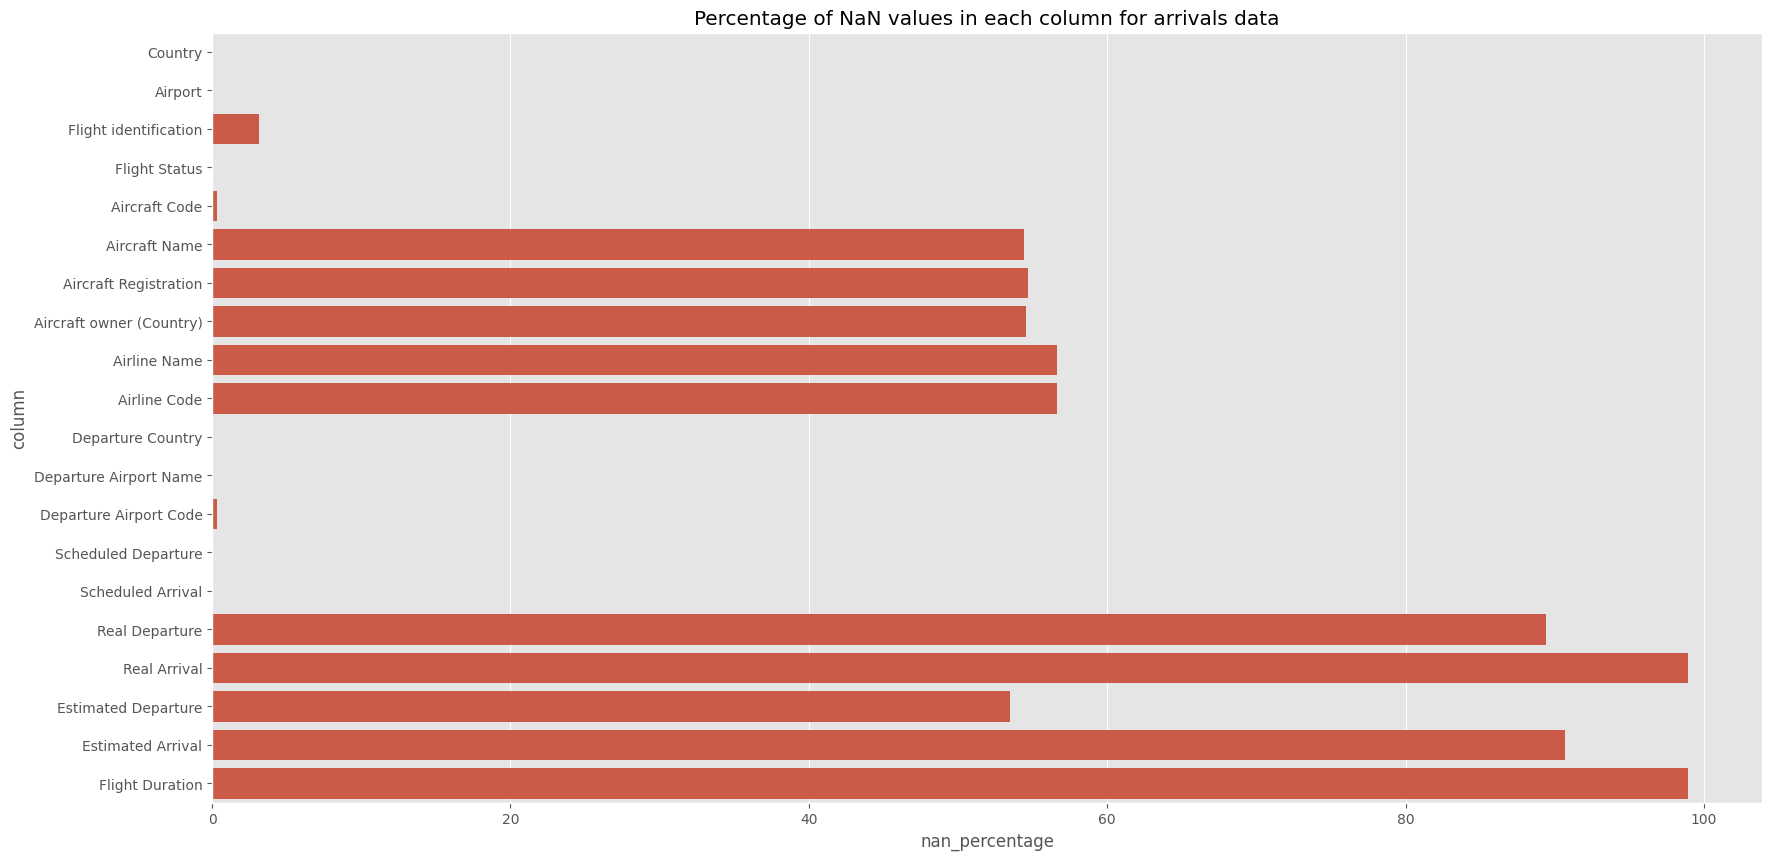

In [274]:
stats_df_arr = plot_nan_percentage(df_arrivals, "Percentage of NaN values in each column for arrivals data")

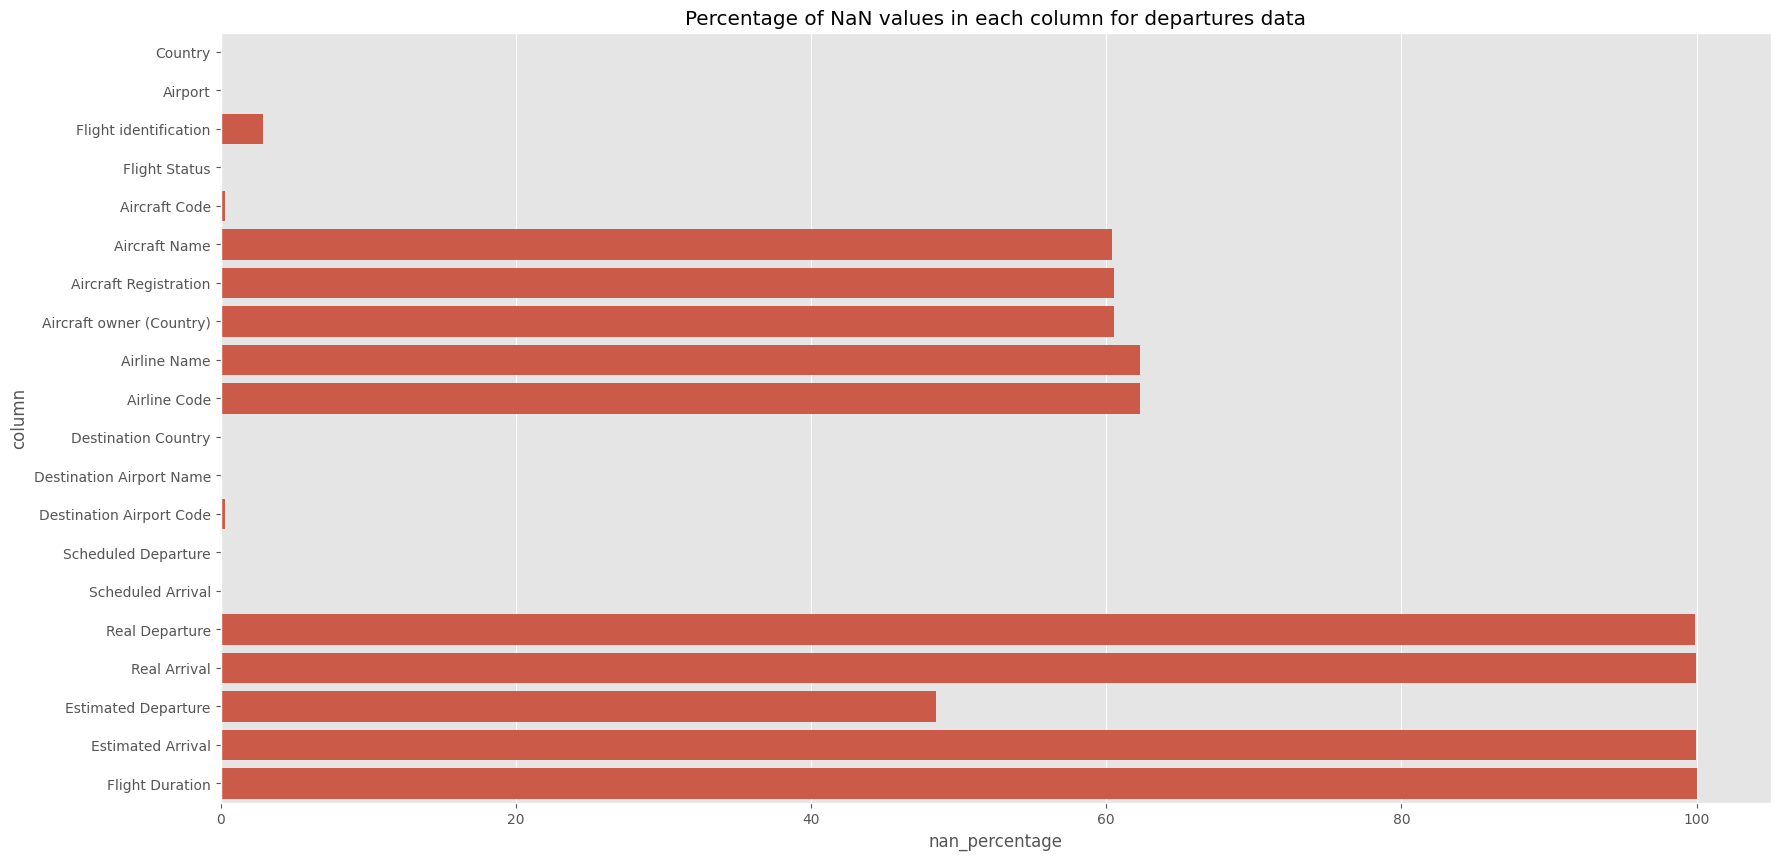

In [275]:
stats_df_dep = plot_nan_percentage(df_departures, "Percentage of NaN values in each column for departures data")

``Data cleaning``
- Nous allons retirer les colonnes avec beaucoup de valeurs manque + de 60%

In [276]:
df_arrivals_cleaned = df_arrivals[pd.notna(df_arrivals["Airline Name"])]
df_departures_cleaned = df_departures[pd.notna(df_departures["Airline Name"])]

df_arrivals_cleaned.shape, df_departures_cleaned.shape, df_low_cost.shape

((33643, 20), (29259, 20), (179, 1))

In [277]:
columns_to_drop = stats_df_arr[stats_df_arr["nan_percentage"] > 60]["column"].values
df_arrivals_cleaned = df_arrivals_cleaned.drop(columns=columns_to_drop)

In [278]:
columns_to_drop = stats_df_dep[stats_df_dep["nan_percentage"] > 65]["column"].values
df_departures_cleaned = df_departures_cleaned.drop(columns=columns_to_drop)

``Data seperation between low-cost and high-cost company``
- On récupère les companies low-cost et fullservice séparemment

In [279]:
def separate_df(df):
    df_low_cost_service = df[df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    df_full_service = df[~df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    return df_low_cost_service, df_full_service

df_arrivals_low_cost, df_arrivals_full_service = separate_df(df_arrivals_cleaned)
df_departures_low_cost, df_departures_full_service = separate_df(df_departures_cleaned)

In [280]:
df_arrivals_low_cost.shape, df_arrivals_full_service.shape, df_departures_low_cost.shape, df_departures_full_service.shape

((8034, 16), (25609, 16), (7444, 16), (21815, 16))

- On vérifie aussi la répartition des valeurs manquantes

<Axes: title={'center': 'Number of NaN values per column for low cost airlines arrivals data'}>

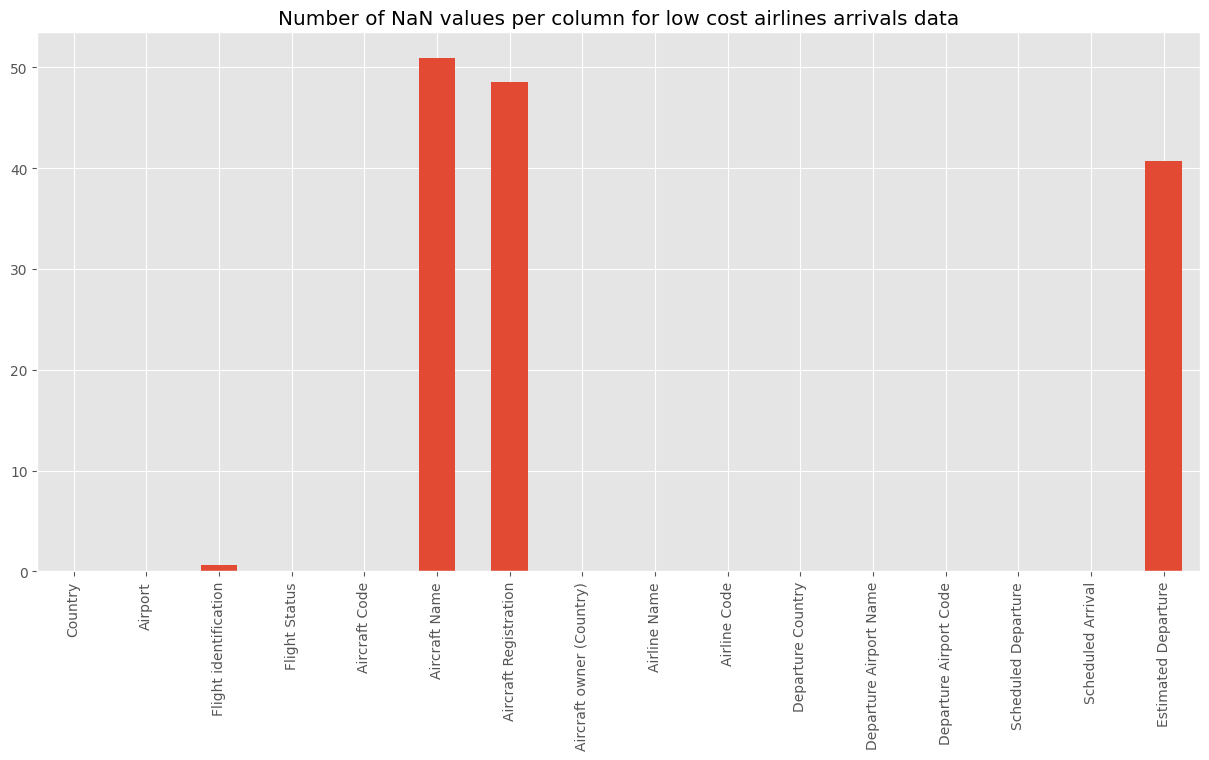

In [281]:
def convert_to_percentage(x):
    return (x / df_arrivals_low_cost.shape[0]) * 100

df_arrivals_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for high cost airlines arrivals data'}>

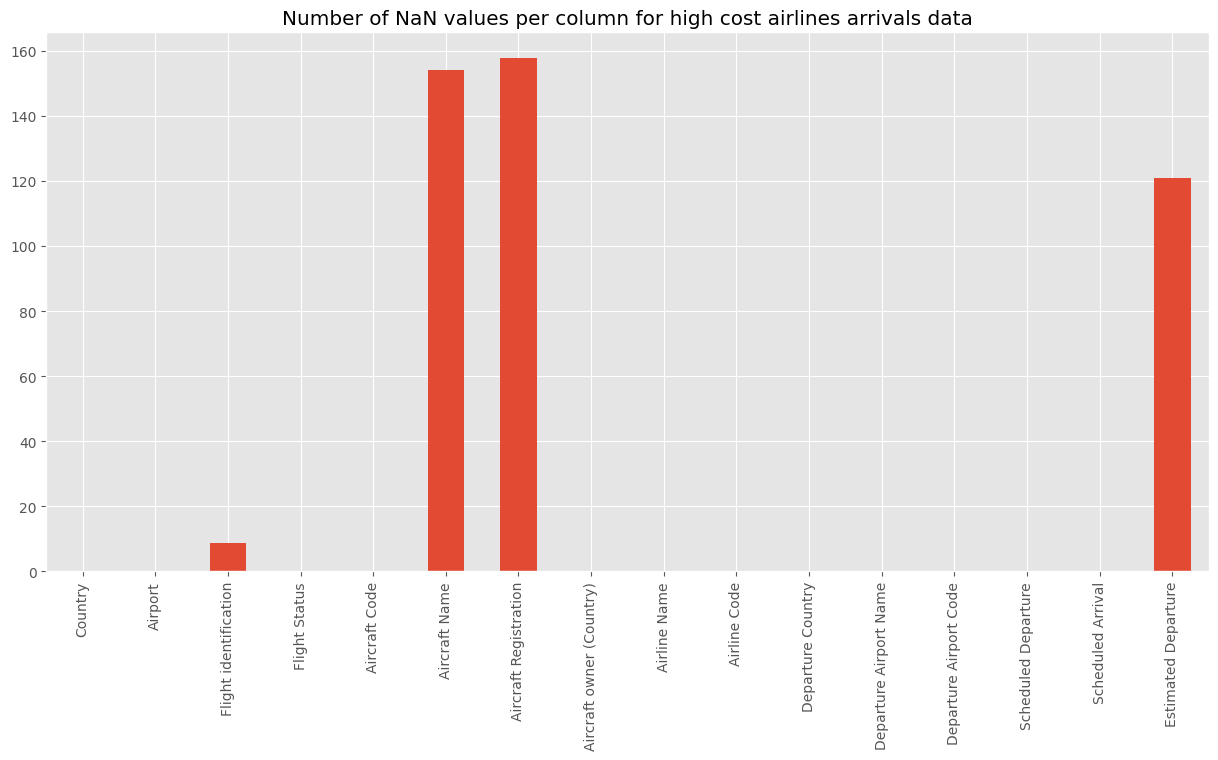

In [282]:
df_arrivals_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for high cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for low cost airlines departures data'}>

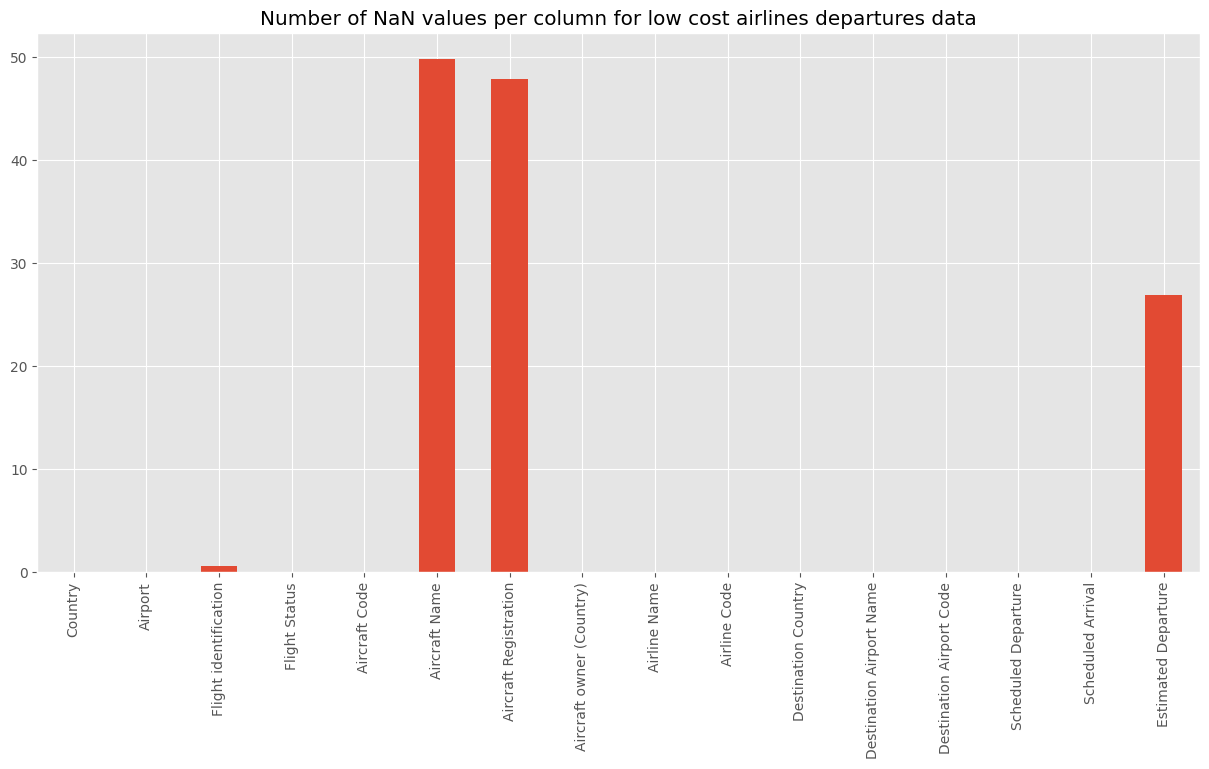

In [283]:
df_departures_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines departures data")

<Axes: title={'center': 'Number of NaN values per column high low cost airlines departures data'}>

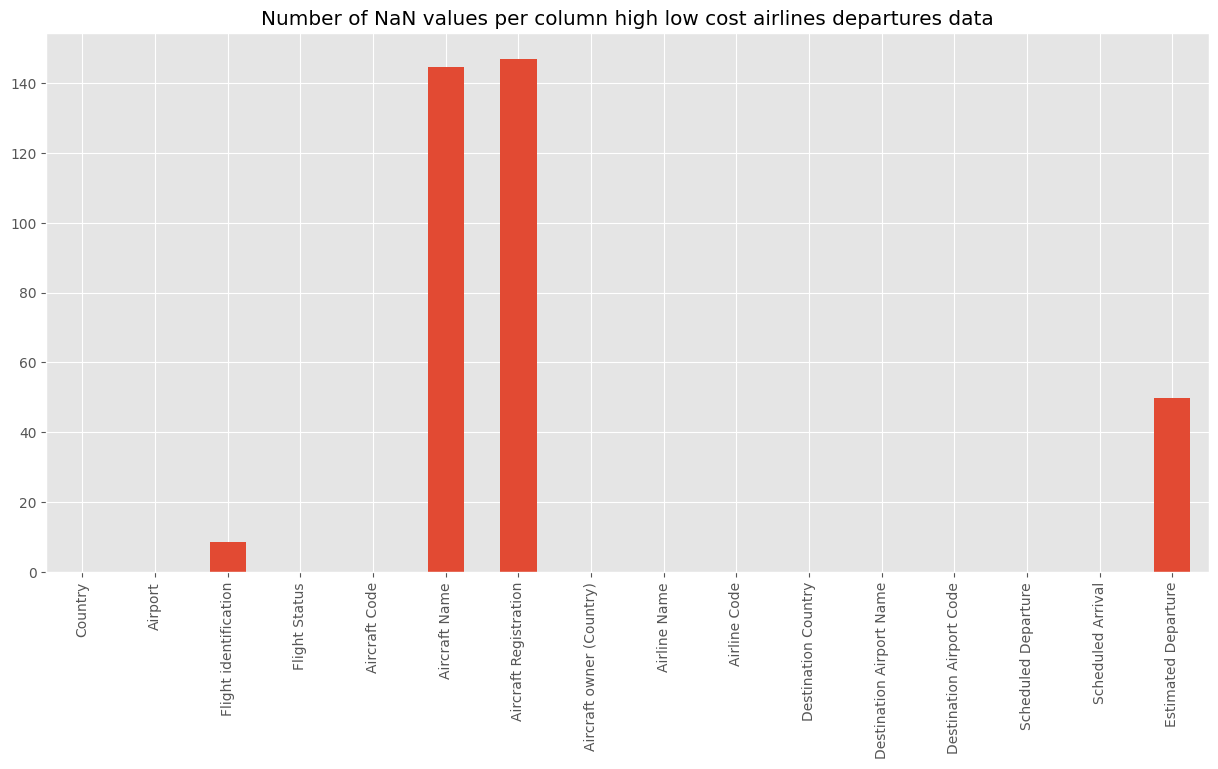

In [284]:
df_departures_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column high low cost airlines departures data")

``Number of low cost company vs full service`` 
- On constate clairement que en générale on a bien plus de companies full-service que low-cost (3x +)

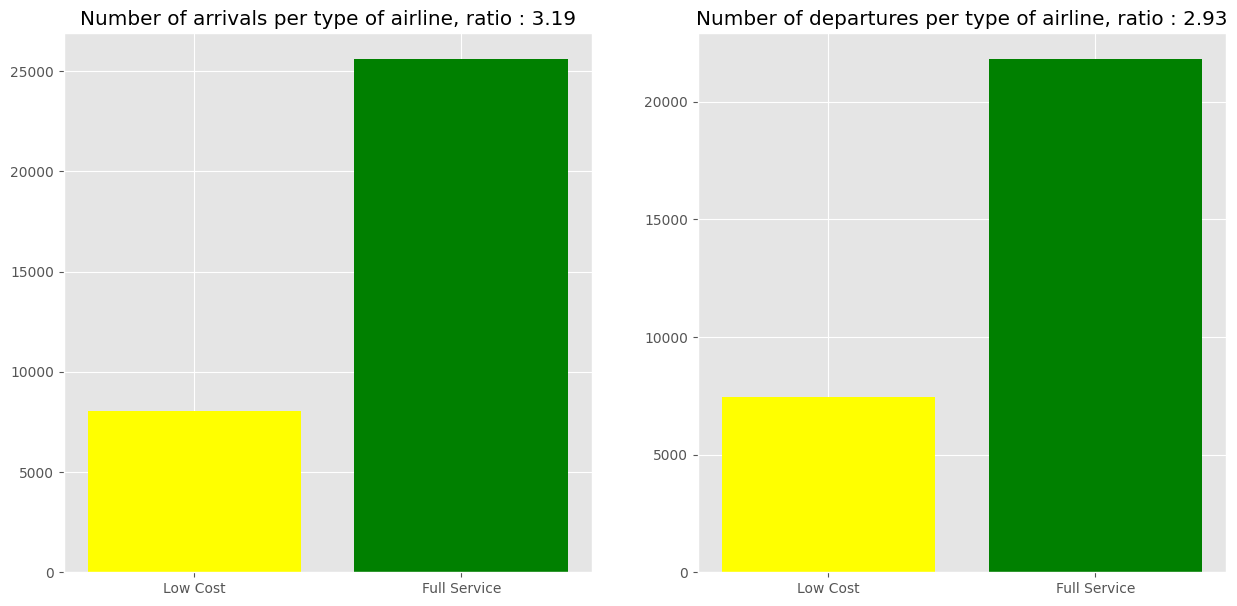

In [285]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.bar(["Low Cost", "Full Service"], [df_arrivals_low_cost.shape[0], df_arrivals_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of arrivals per type of airline, ratio : {df_arrivals_full_service.shape[0] / df_arrivals_low_cost.shape[0]:.2f}")
plt.subplot(1, 2, 2)
plt.bar(["Low Cost", "Full Service"], [df_departures_low_cost.shape[0], df_departures_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of departures per type of airline, ratio : {df_departures_full_service.shape[0] / df_departures_low_cost.shape[0]:.2f}")
plt.show()

``Type of plane``
- Pour celà nous allons d'abord join les datasets sur l'attribut d'index pour pouvoir bien comparer

In [286]:
def join_dataset(df_arrivals, df_departures):
    df_matched = df_arrivals.join(df_departures, how='inner', lsuffix='_arr', rsuffix='_dep')
    columns_to_drop = [col for col in df_matched.columns if col.endswith('_dep') and col[:-4] + '_arr' in df_matched.columns]
    df_matched.drop(columns=columns_to_drop, inplace=True)
    df_matched.rename(columns=lambda x: x.replace('_arr', ''), inplace=True)
    return df_matched

df_matched_low_cost = join_dataset(df_arrivals_low_cost, df_departures_low_cost)
df_matched_full_service = join_dataset(df_arrivals_full_service, df_departures_full_service)

df_matched_low_cost.shape, df_matched_full_service.shape

((3137, 19), (13745, 19))

In [287]:
aircraft_low_cost = df_matched_low_cost.groupby("Aircraft Code").apply(len).sort_values(ascending=False)
aircraft_full_service = df_matched_full_service.groupby("Aircraft Code").apply(len).sort_values(ascending=False)

- Tout les codes d'avions

In [288]:
all_aircraf_code = list(set(df_arrivals["Aircraft Code"].unique()).union(df_departures["Aircraft Code"].unique()))

In [289]:
aircraft_low_cost_complete = aircraft_low_cost.reindex(all_aircraf_code, fill_value=0)
aircraft_full_service_complete = aircraft_full_service.reindex(all_aircraf_code, fill_value=0)
combined_aircraft_usage = pd.concat([aircraft_low_cost_complete, aircraft_full_service_complete], axis=1, keys=['Low Cost', 'Full Service'])

In [290]:
df_matched_low_cost.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A20N,515,10,IndiGo,343
A21N,224,18,IndiGo,146
A319,109,9,Allegiant Air,33
A320,643,18,AirAsia,101
A321,48,9,JetBlue Airways,14
A333,3,2,AirAsia X,2
A359,1,1,French Bee,1
A35K,1,1,French Bee,1
AT75,1,1,Firefly,1


In [291]:
df_matched_full_service.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A139,3,2,Offshore Helicopter Services,2
A20N,736,57,Azul Linhas Aereas,196
A21N,391,48,Wizz Air Malta,63
A306,28,5,European Air Transport,16
A310,2,1,ULS Airlines Cargo,2
...,...,...,...,...
SB20,2,1,Nyxair,2
SF34,96,8,Rex,49
SU95,15,4,Rossiya,9


In [292]:
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False)

,Low Cost,Full Service
Aircraft Code,,
A320,643,1655
B738,530,1386
A20N,515,736
B737,429,260
B38M,312,423
...,...,...
BE4W,0,1
P46T,0,0
GLF3,0,0


- On constate clairement que les avions les plus utilisés sont commun au deux type de companies: 
    - A320, B738, A20N
- Cependant pendant que les companies low-cost conitnues d'utiliser que des avions moyen-courrier: 
    - B737, B38M
- Les companies full-service utilise beaucoup plus les avions long-courrier : 
    - A333, B788, B772, A359, B789
- Tres tres peu d'avion long courrier sont utilisé par les companies low-cost : 
    'Air Europa', 'Jetstar', 'Thai AirAsia X', 'Scoot', 'AirAsia X',
    'Lion Air', 'Jin Air'

<Figure size 3000x1200 with 0 Axes>

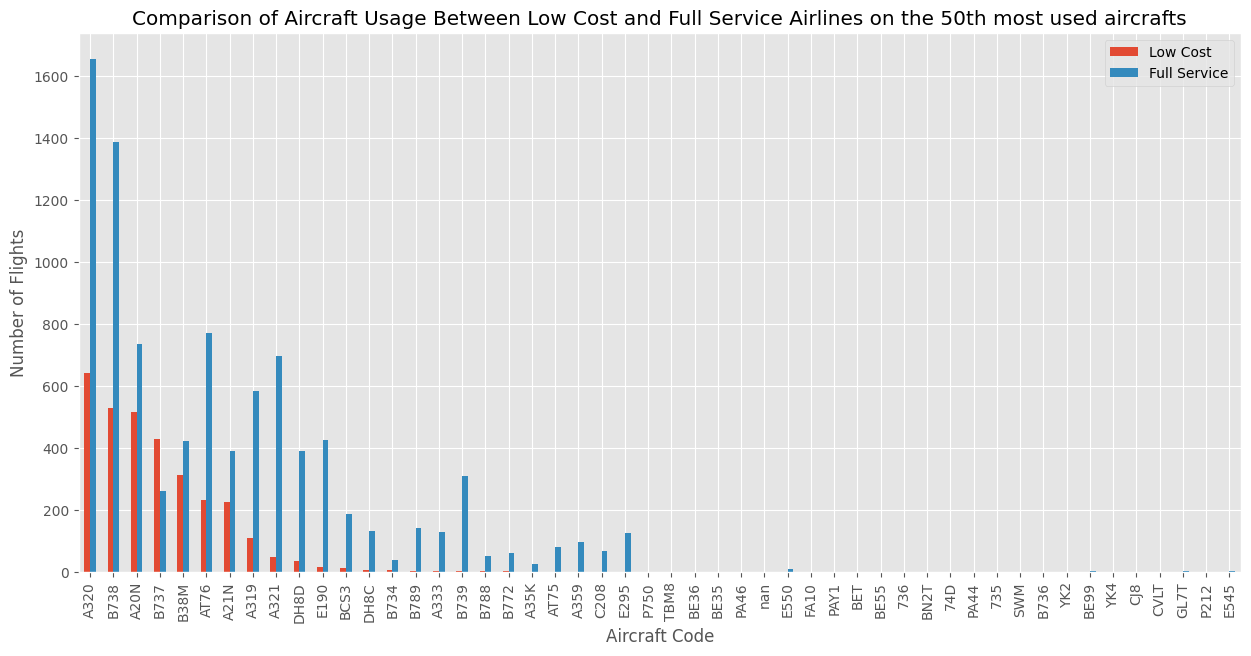

In [293]:
plt.figure(figsize=(30,12))
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False).iloc[:50].plot(kind="bar", figsize=(15, 7), title="Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 20th most used aircrafts")
plt.xlabel("Aircraft Code")
plt.ylabel("Number of Flights")
plt.title("Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 50th most used aircrafts")
plt.legend()
plt.xticks(rotation=90)
plt.show()

- Companies low-cost qui utilise des avions long-courrier

In [294]:
long_range_code = ["B789","B788","B772","A333"]

companies_that_use_long_range = df_arrivals_low_cost[df_arrivals_low_cost["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()
companies_that_use_long_range_full_service = df_arrivals_full_service[df_arrivals_full_service["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()

print("Number of low cost airlines that use long range aircrafts : ", len(companies_that_use_long_range))
print("Number of full service airlines that use long range aircrafts : ", len(companies_that_use_long_range_full_service))

Number of low cost airlines that use long range aircrafts :  7
Number of full service airlines that use long range aircrafts :  90


``Aéroport de départ par companies low-cost``

In [340]:
def preprocess(airport):
    airport = airport.lower()
    airport = airport.strip()
    return airport

In [354]:
number_of_airport_arrivals = len(df_arrivals_low_cost["Airport"].unique())
number_of_international_airport_arrivals = len(set(df_arrivals_low_cost["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))

print("On the ", number_of_airport_arrivals, " airports that low cost airlines arrive from, ", number_of_international_airport_arrivals, " are international airports")
print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

On the  961  airports that low cost airlines arrive from,  299  are international airports
Ratio : 31.113423517169615%


``Aéroport de départ par companies full-service``

In [359]:
number_of_airport_arrivals = len(df_arrivals_full_service["Airport"].unique())
number_of_international_airport_arrivals = len(set(df_arrivals_full_service["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))

print("On the ", number_of_airport_arrivals, " airports that low cost airlines arrive from, ", number_of_international_airport_arrivals, " are international airports")
print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

On the  2089  airports that low cost airlines arrive from,  479  are international airports
Ratio : 22.929631402584967%


``Aéroport déservies par companies low-cost``

In [358]:
number_of_airport_arrivals = len(df_departures_low_cost["Airport"].unique())
number_of_international_airport_arrivals = len(set(df_departures_low_cost["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))

print("On the ", number_of_airport_arrivals, " airports that low cost airlines deserve, ", number_of_international_airport_arrivals, " are international airports")
print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

On the  821  airports that low cost airlines deserve,  239  are international airports
Ratio : 29.11084043848965%


``Aéroport déservies par companies low-cost``

In [361]:
number_of_airport_arrivals = len(df_departures_full_service["Airport"].unique())
number_of_international_airport_arrivals = len(set(df_departures_full_service["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))

print("On the ", number_of_airport_arrivals, " airports that low cost airlines deserve, ", number_of_international_airport_arrivals, " are international airports")
print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

On the  1874  airports that low cost airlines deserve,  438  are international airports
Ratio : 23.372465314834578%
